In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import yfinance as yfin
import scipy
import MH4518.WY.Utils.constants as cs
import MH4518.WY.Utils.Dates as dates 
import MH4518.WY.Utils.payoff as pf
import MH4518.WY.Utils.GBM as gbm
import MH4518.WY.Utils.ProductPrice as pp 

import warnings
warnings.filterwarnings("ignore")
import multiprocessing as mp
import pandas as pd
import logging


In [2]:
def getdata():
    data = yfin.download(['LONN.SW', 'SIKA.SW'], period= 'max')['Adj Close']
    data.index = data.index.tz_localize(None)
    data = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    return data 

data = getdata()

[*********************100%***********************]  2 of 2 completed


In [3]:
def read_hist_rates():
    swiss_1_week = pd.read_csv(r'C:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\Data\Switzerland 1-Week Bond Yield Historical Data.csv', index_col = 0, parse_dates=True, infer_datetime_format=True)
    swiss_1_month = pd.read_csv(r'C:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\Data\Switzerland 1-Month Bond Yield Historical Data.csv', index_col = 0 , parse_dates=True, infer_datetime_format=True)
    swiss_2_month = pd.read_csv(r'C:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\Data\Switzerland 2-Month Bond Yield Historical Data.csv', index_col = 0 , parse_dates=True, infer_datetime_format=True)
    swiss_6_month = pd.read_csv(r'C:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\Data\Switzerland 6-Month Bond Yield Historical Data.csv', index_col = 0 , parse_dates=True, infer_datetime_format=True)
    swiss_1_year = pd.read_csv(r'C:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\Data\Switzerland 1-Year Bond Yield Historical Data.csv' , index_col = 0 , parse_dates=True, infer_datetime_format=True)
    combined = pd.concat([swiss_1_week[["Price"]], swiss_1_month[["Price"]], swiss_2_month[["Price"]], swiss_6_month[["Price"]], swiss_1_year[["Price"]]], axis = 1)
    combined.columns = ["1 week Price", "1 month Price", "2 month Price", "6 month Price", "1 Year Price"]
   
    return combined

df = read_hist_rates()
df


1 week Price  1 month Price  2 month Price  6 month Price  \
Date                                                                    
2022-04-01         -0.77          -0.80          -0.71          -0.70   
2022-04-02         -0.77          -0.90          -0.74          -0.70   
2022-04-03         -1.00          -0.80          -0.80          -0.70   
2022-04-04         -0.89          -0.90          -0.71          -0.70   
2022-04-05         -0.95          -0.90          -0.71          -0.70   
...                  ...            ...            ...            ...   
2024-10-28          0.77           0.69           0.60           0.51   
2024-10-29          0.85           0.77           0.80           0.51   
2024-10-30          0.77           0.68           0.80           0.51   
2024-10-31          0.71           0.65           0.79           0.50   
2024-11-01          0.73           0.67           0.79           0.47   

            1 Year Price  
Date                      
2022-04-01         -0.57  
2022-04-02           NaN  
2022-04-03         -0.57  
2022-04-04         -0.55  
2022-04-05         -0.55  
...                  ...  
2024-10-28          0.56  
2024-10-29          0.61  
2024-10-30          0.62  
2024-10-31          0.61  
2024-11-01          0.60  

[895 rows x 5 columns]

In [4]:
maturity_to_years = {
    '1 week Price': 1/52,
    '1 month Price': 1/12,
    '2 month Price': 2/12,
    '6 month Price': 6/12,
    '1 Year Price': 1
}
maturities = df.columns.tolist()
times_to_maturity = np.array([maturity_to_years[m] for m in maturities])

In [5]:
for col in df.columns:
    df[col] = df[col].apply(lambda x: np.exp(-x/100*maturity_to_years[col]))
df

1 week Price  1 month Price  2 month Price  6 month Price  \
Date                                                                    
2022-04-01      1.000148       1.000667       1.001184       1.003506   
2022-04-02      1.000148       1.000750       1.001234       1.003506   
2022-04-03      1.000192       1.000667       1.001334       1.003506   
2022-04-04      1.000171       1.000750       1.001184       1.003506   
2022-04-05      1.000183       1.000750       1.001184       1.003506   
...                  ...            ...            ...            ...   
2024-10-28      0.999852       0.999425       0.999000       0.997453   
2024-10-29      0.999837       0.999359       0.998668       0.997453   
2024-10-30      0.999852       0.999433       0.998668       0.997453   
2024-10-31      0.999863       0.999458       0.998684       0.997503   
2024-11-01      0.999860       0.999442       0.998684       0.997653   

            1 Year Price  
Date                      
2022-04-01      1.005716  
2022-04-02           NaN  
2022-04-03      1.005716  
2022-04-04      1.005515  
2022-04-05      1.005515  
...                  ...  
2024-10-28      0.994416  
2024-10-29      0.993919  
2024-10-30      0.993819  
2024-10-31      0.993919  
2024-11-01      0.994018  

[895 rows x 5 columns]

In [6]:
def vasicek_bond_price(a, b, sigma, r0, T):
    B = (1 - np.exp(-a * T)) / a
    A = (b - (sigma**2) / (2 * a**2)) * (B - T) - (sigma**2) * B**2 / (4 * a)
    P = np.exp(A - B * r0)
    return P

In [7]:
from scipy.optimize import minimize
def calibration_objective(params, bond_maturities, bond_prices, r0):
    a, b, sigma = params
    # Ensure sigma is positive
    if sigma < 0:
        return np.inf
    model_prices = vasicek_bond_price(a, b, sigma, r0, bond_maturities)
    error = bond_prices - model_prices
    return np.sum(error**2)

# ---------------------------
# 3. Calibration Function
# ---------------------------

def calibrate_vasicek(bond_maturities, bond_prices, r0):
    initial_guess = [0.1, 0.05, 0.01]  # [a, b, sigma]
    bounds = [
        (0.01, 1.0),   # a
        (0.01, 0.15),  # b
        (0.001, 0.1)    # sigma
    ]
    
    result = minimize(
        calibration_objective,
        initial_guess,
        args=(bond_maturities, bond_prices, r0),
        method='L-BFGS-B',
        bounds=bounds,
        options={'disp': True}
    )
    
    if result.success:
        calibrated_a, calibrated_b, calibrated_sigma = result.x
        calibrated_params = {
            'a': calibrated_a,
            'b': calibrated_b,
            'sigma': calibrated_sigma
        }
        print(f"Calibration successful: {calibrated_params}")
        return calibrated_params
    else:
        raise ValueError("Calibration failed: " + result.message)

In [8]:
calibrated_params = calibrate_vasicek(times_to_maturity, df.loc[cs.initial_fixing_date], 0.015)

Calibration successful: {'a': np.float64(0.10826990922393587), 'b': np.float64(0.06695567691237256), 'sigma': np.float64(0.008832060537589417)}


In [9]:
def simulate_vasicek(a, b, sigma, r0, T, dt, N_simulations):
    """
    Simulate paths for the stochastic Vasicek interest rate model.
    
    Parameters:
    - a: Speed of mean reversion
    - b: Long-term mean level
    - sigma: Volatility of the interest rate
    - r0: Initial interest rate
    - T: Time horizon (years)
    - dt: Time step size
    - N_simulations: Number of simulation paths
    
    Returns:
    - time_grid: Array of time points
    - r_paths: Simulated interest rate paths (N_simulations x N_steps)
    """
    N_steps = int(T / dt)
    time_grid = np.linspace(0, T, N_steps)
    r_paths = np.zeros((N_simulations, N_steps))
    r_paths[:, 0] = r0
    
    dates = pd.date_range(cs.initial_fixing_date, cs.final_fixing_date)
    for t in range(1, N_steps):
        dr = a * (b - r_paths[:, t-1]) * dt + sigma * np.sqrt(dt) * np.random.randn(N_simulations)
        r_paths[:, t] = r_paths[:, t-1] + dr
    
    return time_grid, r_paths



In [10]:
a_calibrated = calibrated_params['a']
b_calibrated = calibrated_params['b']
sigma_r_calibrated = calibrated_params['sigma']

time_grid, r_paths = simulate_vasicek(a_calibrated, b_calibrated, sigma_r_calibrated, 0.015, (461/365), 1/365, 100)

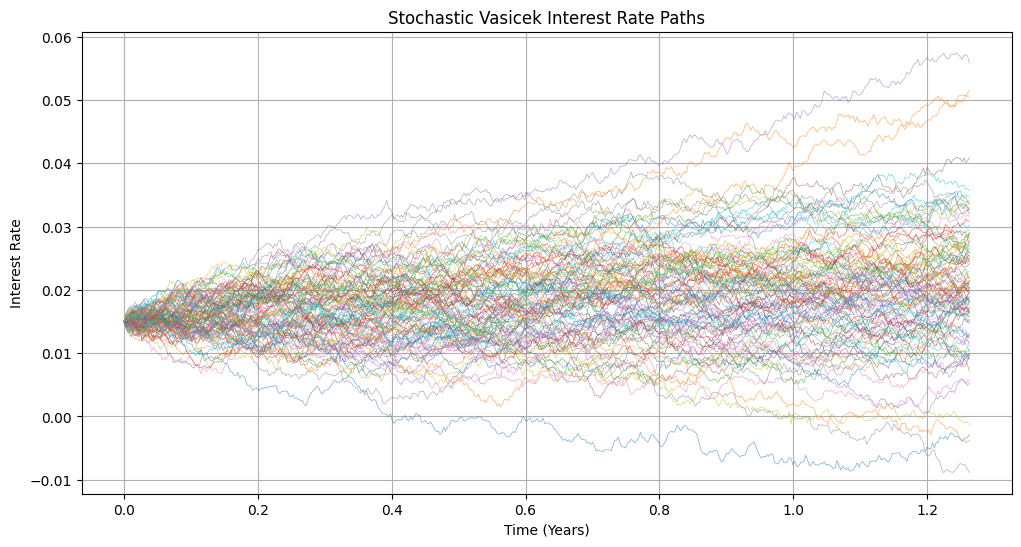

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_vasicek_matplotlib(time_grid, r_paths, num_paths=100):
    """
    Plot a subset of Vasicek interest rate paths using Matplotlib.
    
    Parameters:
    - time_grid: Array of time points
    - r_paths: Simulated interest rate paths (N_simulations x N_steps)
    - num_paths: Number of paths to plot
    """
    plt.figure(figsize=(12, 6))
    
    # Randomly select paths to plot
    selected_indices = np.random.choice(r_paths.shape[0], size=num_paths, replace=False)
    
    for idx in selected_indices:
        plt.plot(time_grid, r_paths[idx], lw=0.5, alpha=0.6)
    
    plt.title('Stochastic Vasicek Interest Rate Paths')
    plt.xlabel('Time (Years)')
    plt.ylabel('Interest Rate')
    plt.grid(True)
    plt.show()

# Usage
plot_vasicek_matplotlib(time_grid, r_paths, num_paths=100)



In [12]:
from datetime import datetime
from dateutil.relativedelta import relativedelta


initial_date = cs.initial_fixing_date

new_date = initial_date + relativedelta(years=1, months=3, days = 3)
new_date




Timestamp('2024-07-30 00:00:00')

In [13]:
r_paths = pd.DataFrame(r_paths).T
dates_index= pd.date_range(cs.initial_fixing_date, new_date, inclusive='both')
r_paths.index = dates_index
r_paths

0         1         2         3         4         5   \
2023-04-27  0.015000  0.015000  0.015000  0.015000  0.015000  0.015000   
2023-04-28  0.015710  0.014044  0.014461  0.014391  0.015297  0.014185   
2023-04-29  0.015537  0.014727  0.014982  0.015238  0.014636  0.014355   
2023-04-30  0.015565  0.014648  0.014989  0.014677  0.014727  0.014749   
2023-05-01  0.015389  0.014300  0.015716  0.014713  0.014893  0.015715   
...              ...       ...       ...       ...       ...       ...   
2024-07-26  0.022430  0.032020  0.026628  0.017918  0.034136 -0.003847   
2024-07-27  0.023095  0.032233  0.026658  0.018473  0.034042 -0.003570   
2024-07-28  0.023319  0.032595  0.027506  0.017432  0.033787 -0.003372   
2024-07-29  0.022244  0.032582  0.028084  0.017168  0.034031 -0.003259   
2024-07-30  0.021878  0.032810  0.027412  0.016479  0.033492 -0.002867   

                  6         7         8         9   ...        90        91  \
2023-04-27  0.015000  0.015000  0.015000  0.015000  ...  0.015000  0.015000   
2023-04-28  0.015031  0.014567  0.014633  0.015466  ...  0.015954  0.016052   
2023-04-29  0.015568  0.014316  0.015208  0.015819  ...  0.016735  0.016003   
2023-04-30  0.015667  0.015263  0.014740  0.015952  ...  0.017303  0.016574   
2023-05-01  0.015831  0.015424  0.015474  0.016644  ...  0.017242  0.017056   
...              ...       ...       ...       ...  ...       ...       ...   
2024-07-26  0.021489  0.015967  0.018980  0.018057  ...  0.024377  0.026878   
2024-07-27  0.021575  0.015934  0.020383  0.018591  ...  0.025051  0.026294   
2024-07-28  0.021050  0.016150  0.020954  0.018720  ...  0.025600  0.025927   
2024-07-29  0.020830  0.016216  0.021044  0.019023  ...  0.026278  0.025989   
2024-07-30  0.021208  0.016544  0.020936  0.019807  ...  0.026537  0.026114   

                  92        93        94        95        96        97  \
2023-04-27  0.015000  0.015000  0.015000  0.015000  0.015000  0.015000   
2023-04-28  0.014784  0.014769  0.015072  0.016085  0.015458  0.015502   
2023-04-29  0.015121  0.014947  0.014965  0.016093  0.016017  0.014977   
2023-04-30  0.015501  0.015449  0.015470  0.015024  0.015742  0.014855   
2023-05-01  0.015935  0.015926  0.015242  0.014693  0.014855  0.015098   
...              ...       ...       ...       ...       ...       ...   
2024-07-26  0.009549  0.034971  0.017789  0.020597  0.025537  0.008132   
2024-07-27  0.008991  0.034428  0.017540  0.021106  0.024828  0.009046   
2024-07-28  0.009170  0.034706  0.018271  0.022598  0.025758  0.008852   
2024-07-29  0.009664  0.033862  0.019200  0.022377  0.025624  0.008146   
2024-07-30  0.009896  0.034056  0.019533  0.022421  0.025217  0.007169   

                  98        99  
2023-04-27  0.015000  0.015000  
2023-04-28  0.015570  0.015379  
2023-04-29  0.015301  0.015532  
2023-04-30  0.014380  0.015352  
2023-05-01  0.014708  0.015133  
...              ...       ...  
2024-07-26  0.025435  0.024755  
2024-07-27  0.025273  0.024994  
2024-07-28  0.024174  0.025179  
2024-07-29  0.024365  0.025191  
2024-07-30  0.024555  0.024563  

[461 rows x 100 columns]

In [14]:
r_paths

0         1         2         3         4         5   \
2023-04-27  0.015000  0.015000  0.015000  0.015000  0.015000  0.015000   
2023-04-28  0.015710  0.014044  0.014461  0.014391  0.015297  0.014185   
2023-04-29  0.015537  0.014727  0.014982  0.015238  0.014636  0.014355   
2023-04-30  0.015565  0.014648  0.014989  0.014677  0.014727  0.014749   
2023-05-01  0.015389  0.014300  0.015716  0.014713  0.014893  0.015715   
...              ...       ...       ...       ...       ...       ...   
2024-07-26  0.022430  0.032020  0.026628  0.017918  0.034136 -0.003847   
2024-07-27  0.023095  0.032233  0.026658  0.018473  0.034042 -0.003570   
2024-07-28  0.023319  0.032595  0.027506  0.017432  0.033787 -0.003372   
2024-07-29  0.022244  0.032582  0.028084  0.017168  0.034031 -0.003259   
2024-07-30  0.021878  0.032810  0.027412  0.016479  0.033492 -0.002867   

                  6         7         8         9   ...        90        91  \
2023-04-27  0.015000  0.015000  0.015000  0.015000  ...  0.015000  0.015000   
2023-04-28  0.015031  0.014567  0.014633  0.015466  ...  0.015954  0.016052   
2023-04-29  0.015568  0.014316  0.015208  0.015819  ...  0.016735  0.016003   
2023-04-30  0.015667  0.015263  0.014740  0.015952  ...  0.017303  0.016574   
2023-05-01  0.015831  0.015424  0.015474  0.016644  ...  0.017242  0.017056   
...              ...       ...       ...       ...  ...       ...       ...   
2024-07-26  0.021489  0.015967  0.018980  0.018057  ...  0.024377  0.026878   
2024-07-27  0.021575  0.015934  0.020383  0.018591  ...  0.025051  0.026294   
2024-07-28  0.021050  0.016150  0.020954  0.018720  ...  0.025600  0.025927   
2024-07-29  0.020830  0.016216  0.021044  0.019023  ...  0.026278  0.025989   
2024-07-30  0.021208  0.016544  0.020936  0.019807  ...  0.026537  0.026114   

                  92        93        94        95        96        97  \
2023-04-27  0.015000  0.015000  0.015000  0.015000  0.015000  0.015000   
2023-04-28  0.014784  0.014769  0.015072  0.016085  0.015458  0.015502   
2023-04-29  0.015121  0.014947  0.014965  0.016093  0.016017  0.014977   
2023-04-30  0.015501  0.015449  0.015470  0.015024  0.015742  0.014855   
2023-05-01  0.015935  0.015926  0.015242  0.014693  0.014855  0.015098   
...              ...       ...       ...       ...       ...       ...   
2024-07-26  0.009549  0.034971  0.017789  0.020597  0.025537  0.008132   
2024-07-27  0.008991  0.034428  0.017540  0.021106  0.024828  0.009046   
2024-07-28  0.009170  0.034706  0.018271  0.022598  0.025758  0.008852   
2024-07-29  0.009664  0.033862  0.019200  0.022377  0.025624  0.008146   
2024-07-30  0.009896  0.034056  0.019533  0.022421  0.025217  0.007169   

                  98        99  
2023-04-27  0.015000  0.015000  
2023-04-28  0.015570  0.015379  
2023-04-29  0.015301  0.015532  
2023-04-30  0.014380  0.015352  
2023-05-01  0.014708  0.015133  
...              ...       ...  
2024-07-26  0.025435  0.024755  
2024-07-27  0.025273  0.024994  
2024-07-28  0.024174  0.025179  
2024-07-29  0.024365  0.025191  
2024-07-30  0.024555  0.024563  

[461 rows x 100 columns]

In [15]:
len(dates_index)

461

In [16]:
date_list = dates.get_list_dates(cs.initial_fixing_date, cs.final_fixing_date)
date_list = pd.Series(date_list).tolist()
date_list

[Timestamp('2023-04-27 00:00:00'),
 Timestamp('2023-04-28 00:00:00'),
 Timestamp('2023-05-02 00:00:00'),
 Timestamp('2023-05-03 00:00:00'),
 Timestamp('2023-05-04 00:00:00'),
 Timestamp('2023-05-05 00:00:00'),
 Timestamp('2023-05-08 00:00:00'),
 Timestamp('2023-05-09 00:00:00'),
 Timestamp('2023-05-10 00:00:00'),
 Timestamp('2023-05-11 00:00:00'),
 Timestamp('2023-05-12 00:00:00'),
 Timestamp('2023-05-15 00:00:00'),
 Timestamp('2023-05-16 00:00:00'),
 Timestamp('2023-05-17 00:00:00'),
 Timestamp('2023-05-19 00:00:00'),
 Timestamp('2023-05-22 00:00:00'),
 Timestamp('2023-05-23 00:00:00'),
 Timestamp('2023-05-24 00:00:00'),
 Timestamp('2023-05-25 00:00:00'),
 Timestamp('2023-05-26 00:00:00'),
 Timestamp('2023-05-30 00:00:00'),
 Timestamp('2023-05-31 00:00:00'),
 Timestamp('2023-06-01 00:00:00'),
 Timestamp('2023-06-02 00:00:00'),
 Timestamp('2023-06-05 00:00:00'),
 Timestamp('2023-06-06 00:00:00'),
 Timestamp('2023-06-07 00:00:00'),
 Timestamp('2023-06-08 00:00:00'),
 Timestamp('2023-06-

In [17]:
def multi_asset_gbm(data: pd.DataFrame, fdos, nsims: int, r_paths) -> pd.DataFrame:
    """
    Simulates multiple asset paths under the risk-neutral measure using GBM for multiple simulations.
    """

    
    try:
        # Prepare the log returns DataFrame
        log_returns_df = pd.DataFrame()
        for ticker in cs.ticker_list:
            log_returns = np.log(data[ticker] / data[ticker].shift(1))
            log_returns_df[ticker] = log_returns
        log_returns_df.dropna(inplace=True)
        
        # Compute the covariance matrix of log returns
        cov_matrix = log_returns_df.cov().values
        vol_vector = np.sqrt(np.diag(cov_matrix))
        corr_matrix = cov_matrix / np.outer(vol_vector, vol_vector)
        L = np.linalg.cholesky(corr_matrix)
        
    except Exception as e:
        print("Error at covariance matrix computation:", e)
        raise
    
    try:
        # Simulation parameters
        date_list = dates.get_list_dates(fdos, cs.final_fixing_date)
        num_steps = len(date_list)  # Number of time steps
        dt = cs.dt  # Time step in years
        
        num_assets = cs.num_ticker  # Number of assets
        
        s0_vector = data.loc[fdos, cs.ticker_list].values  # Initial prices as NumPy array
        
        # Print lengths
        print(f"Length of date_list: {len(date_list)}")
        print(f"Number of time steps (num_steps): {num_steps}")
        
        # Precompute drift terms
        r = np.mean(r_paths.loc[fdos])
        drift = (r - 0.5 * vol_vector ** 2) * dt  # Shape: (num_assets,)
        
        # Generate random variables
        Z = np.random.normal(size=(num_steps - 1, nsims, num_assets))  # Shape: (num_steps-1, nsims, num_assets)
        Z_reshaped = Z.reshape(-1, num_assets)  # Shape: ((num_steps - 1) * nsims, num_assets)
        epsilon = Z_reshaped @ L.T  # Shape: ((num_steps - 1) * nsims, num_assets)
        epsilon = epsilon.reshape(num_steps - 1, nsims, num_assets)  # Shape: (num_steps - 1, nsims, num_assets)
        epsilon = epsilon * np.sqrt(dt)  # Scale by sqrt(dt)
        
        # Initialize array to hold simulated prices
        S = np.zeros((num_steps, nsims, num_assets))  # Shape: (num_steps, nsims, num_assets)
        S[0, :, :] = s0_vector  # Set initial prices for all simulations
        
        # Simulate asset prices
        for t in range(1, num_steps):
            S[t] = S[t - 1] * np.exp(
                drift + vol_vector * epsilon[t - 1]
            )
        
        # Transpose S to shape (num_steps, num_assets, nsims)
        S_transposed = S.transpose(0, 2, 1)  # Swap axes 1 and 2
        
        # Reshape S_transposed to (num_steps, num_assets * nsims)
        S_reshaped = S_transposed.reshape(num_steps, num_assets * nsims)
        
        # Build MultiIndex columns
        assets = cs.ticker_list
        simulations = [f'sim{n+1}' for n in range(nsims)]
        arrays = [[], []]
        for asset in assets:
            for sim in simulations:
                arrays[0].append(asset)
                arrays[1].append(sim)
        tuples = list(zip(*arrays))
        index = pd.MultiIndex.from_tuples(tuples, names=['Asset', 'Simulation'])
        
        # Create DataFrame
        sim_data = pd.DataFrame(S_reshaped, index=date_list)
        sim_data.columns = index
        
    except Exception as e:
        print("Error during simulation:", e)
        raise
        
    return sim_data

In [18]:
multi_asset_gbm(data = data, fdos = cs.initial_fixing_date, nsims=100, r_paths=r_paths)

Length of date_list: 315
Number of time steps (num_steps): 315


Asset          LONN.SW                                                  \
Simulation        sim1        sim2        sim3        sim4        sim5   
2023-04-27  542.120544  542.120544  542.120544  542.120544  542.120544   
2023-04-28  541.724958  541.894208  540.721429  542.688648  543.084490   
2023-05-02  542.047921  541.980272  540.359006  542.386249  542.975214   
2023-05-03  543.117502  540.900071  540.493343  543.484930  542.222836   
2023-05-04  542.101298  540.247212  540.895671  542.668195  542.713990   
...                ...         ...         ...         ...         ...   
2024-07-24  563.221443  552.290388  546.892650  588.824374  560.526664   
2024-07-25  563.558887  552.430867  546.856541  587.778446  560.501194   
2024-07-26  563.432716  552.479221  545.529658  586.712377  561.083251   
2024-07-29  564.105779  552.005138  546.132721  586.773081  561.003046   
2024-07-30  563.407851  553.059469  544.671111  587.765633  560.518439   

Asset                                                                   ...  \
Simulation        sim6        sim7        sim8        sim9       sim10  ...   
2023-04-27  542.120544  542.120544  542.120544  542.120544  542.120544  ...   
2023-04-28  542.125729  541.812527  543.025276  541.959705  542.146198  ...   
2023-05-02  543.297440  540.497476  542.050680  542.306821  542.033387  ...   
2023-05-03  544.025091  539.721898  542.344916  542.036273  540.217680  ...   
2023-05-04  544.512261  538.231614  543.908593  542.333894  539.961442  ...   
...                ...         ...         ...         ...         ...  ...   
2024-07-24  543.064291  523.904882  560.158716  554.604412  527.709604  ...   
2024-07-25  542.487444  524.324089  560.544769  554.336282  528.127611  ...   
2024-07-26  542.762218  524.480714  560.741020  555.068199  527.286915  ...   
2024-07-29  542.746049  524.131745  561.333204  554.265790  526.613441  ...   
2024-07-30  543.552050  523.913802  561.702966  554.913348  526.942910  ...   

Asset          SIKA.SW                                                  \
Simulation       sim91       sim92       sim93       sim94       sim95   
2023-04-27  237.429871  237.429871  237.429871  237.429871  237.429871   
2023-04-28  237.595218  237.525634  237.456365  237.342429  237.509368   
2023-05-02  237.743003  237.602818  237.313307  237.554961  237.357664   
2023-05-03  237.238763  237.612005  237.540613  237.842489  237.272757   
2023-05-04  236.943235  237.498063  237.429277  237.883777  237.208859   
...                ...         ...         ...         ...         ...   
2024-07-24  235.953292  241.620833  244.836730  238.635954  246.631784   
2024-07-25  235.794009  241.835748  244.763112  238.537656  246.371734   
2024-07-26  236.042312  241.658546  244.485788  238.294838  246.560888   
2024-07-29  236.326093  241.800548  244.318445  238.369727  246.280293   
2024-07-30  236.733330  241.617257  244.592375  238.441438  246.081229   

Asset                                                                   
Simulation       sim96       sim97       sim98       sim99      sim100  
2023-04-27  237.429871  237.429871  237.429871  237.429871  237.429871  
2023-04-28  237.464036  237.054472  237.421727  237.662585  237.677001  
2023-05-02  237.584282  237.250377  237.590817  237.695535  237.718825  
2023-05-03  237.562922  237.250597  237.529894  237.604592  238.036795  
2023-05-04  237.890967  237.368303  237.682298  237.476054  237.603939  
...                ...         ...         ...         ...         ...  
2024-07-24  246.344252  233.403508  239.781649  241.817404  233.932429  
2024-07-25  246.103242  233.461906  239.895869  241.828972  234.051938  
2024-07-26  245.743245  233.538514  240.379022  241.987270  233.870622  
2024-07-29  245.188527  233.721568  240.414972  242.144464  234.056308  
2024-07-30  245.330745  233.986443  240.911870  242.161211  233.930518  

[315 rows x 200 columns]

In [23]:
def multi_asset_gbm_n_sims(plot: bool, plotasset: bool, nsims: int, data: pd.DataFrame, fdos) -> pd.DataFrame:
    """
    Simulate multiple asset paths under the GBM model for 'nsims' simulations starting from 'fdos'.

    Params:
        plot (bool): Whether to plot the combined simulations.
        plotasset (bool): Whether to plot the simulations for each asset separately.
        nsims (int): Number of simulations to run.
        data (pd.DataFrame): Historical data for assets.
        fdos: First date of simulation.

    Returns:
        sim_data: DataFrame containing simulated asset prices for all simulations.
                  Columns are MultiIndex with levels ('Asset', 'Simulation')
    """

    # Get the list of dates for the simulation period
    date_list = dates.get_list_dates(fdos, cs.final_fixing_date)
    
    # Realized price from initial fixing date to final fixing date
    realised_price = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    
    try:
        # Run the simulation
        sim_data = multi_asset_gbm(data, fdos, nsims, r_paths)
        sim_data.index = date_list
        
    except Exception as e:
        raise Exception("Error during simulation") from e

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        # Plot the realized prices
        realised_price.plot(ax=ax, linewidth=2, label='Realized Price')
        # Plot the simulated paths
        for asset in cs.ticker_list:
            asset_columns = sim_data[asset]
            asset_columns.plot(ax=ax, alpha=0.4, legend=False)
        plt.title('Simulated Paths with Realized Prices')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        ax.legend()  # Add legend for realized price
        plt.show()

    if plotasset:
        for asset in cs.ticker_list:
            # Select columns for the asset
            asset_columns = sim_data[asset]
            # Select the realized price for the asset
            realised_price_asset = realised_price[asset]  # Adjust the column name if necessary

            # Plot asset paths and realized price
            fig, ax = plt.subplots(figsize=(12, 6))
            asset_columns.plot(ax=ax, alpha=0.4, legend=False)
            realised_price_asset.plot(ax=ax, color='black', linewidth=2, label='Realized Price')
            plt.title(f'{asset} Paths under Multi Asset GBM')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.grid(True)
            ax.legend()  # Add legend for realized price
            plt.show()

    return sim_data



Length of date_list: 315
Number of time steps (num_steps): 315


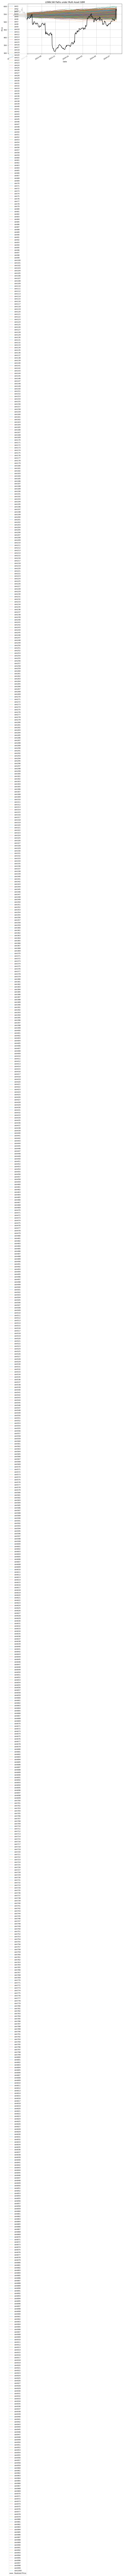

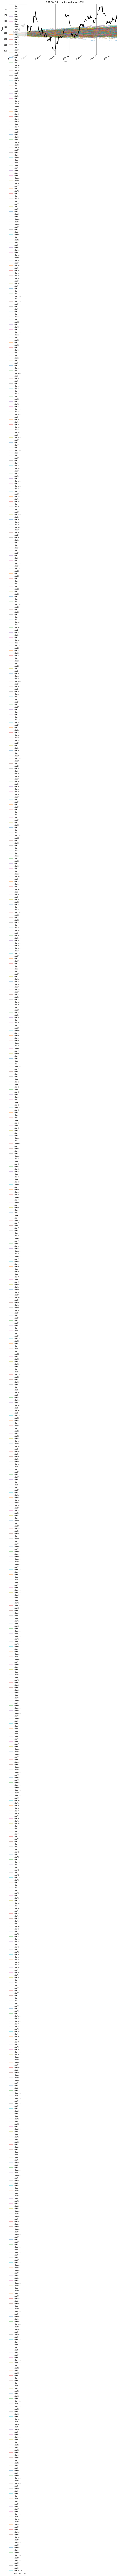

Asset          LONN.SW                                                  \
Simulation        sim1        sim2        sim3        sim4        sim5   
2023-04-27  542.120544  542.120544  542.120544  542.120544  542.120544   
2023-04-28  542.710760  542.378917  542.317322  542.241715  541.212289   
2023-05-02  542.765369  543.022147  543.105549  543.374902  540.892296   
2023-05-03  543.369006  542.923867  543.486547  543.284990  541.574801   
2023-05-04  542.684757  541.523706  542.931265  543.399618  542.480544   
...                ...         ...         ...         ...         ...   
2024-07-24  548.208506  553.211437  541.250674  562.248672  546.424353   
2024-07-25  547.323914  554.933029  542.955827  561.699501  545.174965   
2024-07-26  546.273346  554.843335  543.484107  561.670321  544.058380   
2024-07-29  546.832137  554.906109  542.429363  562.562623  544.818297   
2024-07-30  546.697021  555.068564  541.804420  562.555423  544.299892   

Asset                                                                   ...  \
Simulation        sim6        sim7        sim8        sim9       sim10  ...   
2023-04-27  542.120544  542.120544  542.120544  542.120544  542.120544  ...   
2023-04-28  541.771671  542.504919  541.915856  541.070262  542.589034  ...   
2023-05-02  541.851225  542.064270  541.436387  540.606473  542.804275  ...   
2023-05-03  540.822931  542.893613  541.275632  540.053189  541.691078  ...   
2023-05-04  540.719004  544.595144  540.396641  540.339942  542.005039  ...   
...                ...         ...         ...         ...         ...  ...   
2024-07-24  550.334163  551.793779  552.363057  545.071949  546.805937  ...   
2024-07-25  551.356996  552.575179  551.950149  544.175594  547.337045  ...   
2024-07-26  550.772608  552.608418  552.386821  543.590008  546.985099  ...   
2024-07-29  550.471243  551.783695  551.700030  543.979856  546.731146  ...   
2024-07-30  550.195197  551.186902  550.543967  543.412842  545.517514  ...   

Asset          SIKA.SW                                                  \
Simulation      sim991      sim992      sim993      sim994      sim995   
2023-04-27  237.429871  237.429871  237.429871  237.429871  237.429871   
2023-04-28  237.382112  237.335667  237.113352  237.479628  237.159474   
2023-05-02  237.686656  237.662858  237.088771  237.539322  237.455160   
2023-05-03  237.520023  237.672275  237.198428  237.240069  237.526478   
2023-05-04  237.486217  237.763483  236.949396  237.135584  237.240043   
...                ...         ...         ...         ...         ...   
2024-07-24  248.255724  245.163373  239.549538  248.963314  236.226058   
2024-07-25  248.203274  245.049412  239.309936  249.016873  236.228256   
2024-07-26  247.820795  244.839650  239.703940  248.772764  236.595250   
2024-07-29  247.710107  245.127415  239.372688  248.764531  236.713151   
2024-07-30  247.299749  245.245729  239.566503  248.524426  236.493456   

Asset                                                                   
Simulation      sim996      sim997      sim998      sim999     sim1000  
2023-04-27  237.429871  237.429871  237.429871  237.429871  237.429871  
2023-04-28  237.123904  237.426420  237.440303  237.299872  237.192195  
2023-05-02  236.668981  237.620213  237.821297  237.634698  237.097468  
2023-05-03  236.404776  237.480658  237.776245  237.531143  237.096012  
2023-05-04  236.328509  237.295514  238.081829  237.639149  237.008491  
...                ...         ...         ...         ...         ...  
2024-07-24  237.619443  242.509756  246.299180  243.110865  239.139389  
2024-07-25  237.622423  242.673805  246.025387  243.093778  239.061462  
2024-07-26  237.614610  243.172858  246.229185  243.385123  239.001906  
2024-07-29  237.392782  243.586500  246.474512  243.317449  238.632181  
2024-07-30  237.013583  243.472625  246.434053  243.194132  238.578269  

[315 rows x 2000 columns]

In [25]:
multi_asset_gbm_n_sims(plot=False, plotasset= True, nsims=1000, data=data, fdos = cs.initial_fixing_date)